In [1]:
#Import statements
from sqlalchemy import create_engine
import cx_Oracle
import pandas as pd
import numpy as np
from scipy.stats import normaltest

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#Connect to oracle DB

host='localhost'
port=1521
sid='springboard'
user='springboard'
password='springboard123'
sid = cx_Oracle.makedsn(host, port, sid=sid)

cstr = 'oracle://{user}:{password}@{sid}'.format(
    user=user,
    password=password,
    sid=sid
)

engine =  create_engine(
    cstr,
    convert_unicode=False,
    pool_recycle=10,
    pool_size=50,
    echo=False
)


In [4]:
#Let's continue with our preliminary analysis of the data
#First let's find out which are the most common procedures

query2 = engine.execute('SELECT HCPCS_CODE, HCPCS_DESCRIPTION, COUNT(*) '
                        'FROM MEDICARECHARGESFINAL '
                        'WHERE HCPCS_CODE NOT LIKE {} '
                        'GROUP BY HCPCS_CODE, HCPCS_DESCRIPTION '
                        'HAVING COUNT(*) >= 10000 '
                        'ORDER BY COUNT(*) DESC '.format(("'99%'")))

df2 = pd.DataFrame(query2.fetchall())
df2.columns = query2.keys()
print(df2.head())   

  hcpcs_code                                  hcpcs_description  COUNT(*)
0      G0008          Administration of influenza virus vaccine    140912
1      36415  Insertion of needle into vein for collection o...     93570
2      G0009             Administration of pneumococcal vaccine     89307
3      90662    Vaccine for influenza for injection into muscle     85351
4      93000  Routine EKG using at least 12 leads including ...     83106


In [5]:
#cpt_list - to be used in correlation calculation
#cpt_list_str - CPT codes to be used in query
# refinedList - formats cpt_list_str to be used inside SQL query

cpt_list = df2['hcpcs_code'].tolist()

df2['hcpcs_str'] = '\'' + df2['hcpcs_code'] + '\''
df2.hcpcs_str.head()



cpt_list_str = df2['hcpcs_str'].tolist()

refinedList = ','.join(a for a in cpt_list_str)

In [6]:
query3 = engine.execute('SELECT NPI,HCPCS_CODE, HCPCS_DESCRIPTION, ST_ABBR, FIPS_ST, FIPS_CO, '
                            'AVERAGE_SUBMITTED_CHRG_AMT AS AVG_CHARGES '
                            'FROM MEDICARECHARGESFINAL '
                            'WHERE HCPCS_CODE IN ({}) '.format(refinedList))
df3 = pd.DataFrame(query3.fetchall())
df3.columns = query3.keys()
print(df3.head()) 

          npi hcpcs_code                                  hcpcs_description  \
0  1003000134      88304  Pathology examination of tissue using a micros...   
1  1003000134      88305  Pathology examination of tissue using a micros...   
2  1003000134      88341  Special stained specimen slides to examine tissue   
3  1003000134      88342   Tissue or cell analysis by immunologic technique   
4  1003000407      36556  Insertion of central venous catheter for infus...   

  st_abbr fips_st fips_co avg_charges  
0      IL      17     031         115  
1      IL      17     031         170  
2      IL      17     031          68  
3      IL      17     031         147  
4      PA      42     021         621  


In [19]:
#df3.to_csv('data/MedicareChargesDataCorr.csv',index = None)

In [7]:
#Close DB connection
conn = engine.connect()
conn.close()

In [8]:
#Add FIPS column & convert avg_charges to floats
df3['FIPS'] = df3['fips_st'] + df3['fips_co']
df3['avg_charges'] = pd.to_numeric(df3.avg_charges, downcast='float')
df3.head()

,npi,hcpcs_code,hcpcs_description,st_abbr,fips_st,fips_co,avg_charges,FIPS
0,1003000134,88304,Pathology examination of tissue using a micros...,IL,17,031,115.0,17031
1,1003000134,88305,Pathology examination of tissue using a micros...,IL,17,031,170.0,17031
2,1003000134,88341,Special stained specimen slides to examine tissue,IL,17,031,68.0,17031
3,1003000134,88342,Tissue or cell analysis by immunologic technique,IL,17,031,147.0,17031
4,1003000407,36556,Insertion of central venous catheter for infus...,PA,42,021,621.0,42021


In [9]:
#function to get dataframe with average charges and FIPS data
def get_avg_charges_FIPS(data,cpt):
    data_sel = data[data.hcpcs_code==cpt]
    data_avg_FIPS =data_sel[['FIPS','avg_charges']]
    return data_avg_FIPS

#Test data for function
data_test = get_avg_charges_FIPS(df3,'G0444')
data_test.head()

,FIPS,avg_charges
1220,13073,50.0
2018,48113,50.0
2058,54011,32.0
3423,48113,25.0
3801,39095,53.0


In [10]:
def generate_normal_test(data,cpt_list):
    normal_dict = {}
    for cpt in cpt_list:
        avg_charges_data = get_avg_charges_FIPS(data,cpt)
        stat,p = normaltest(avg_charges_data['avg_charges']) 
        normal_dict[cpt]=p
    return normal_dict    


test_normality = generate_normal_test(df3,cpt_list)

In [12]:
#print(test_normality)
normal_df = pd.DataFrame.from_dict(test_normality, orient='index')
print(normal_df.head())

         0
G0008  0.0
36415  0.0
G0009  0.0
90662  0.0
93000  0.0


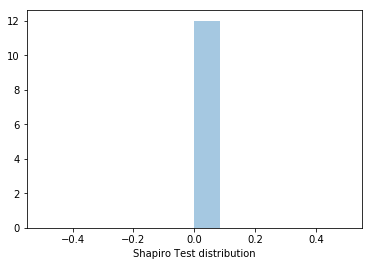

In [25]:
#Print distribution of normality test results
x = pd.Series(list(test_normality.values()), name="Normality use distribution")

ax = sns.distplot(x)

In [28]:
#No correlation between number of providers and charges 